In [1]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'sh-fe080851-d462-4304-9f4d-1b7fd7c7dc95'
config.sh_client_secret = 'XBnxUPfjs1duw9wmexDpoVmhTbY6piHw'
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [2]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

In [3]:
hyd_coords_wgs84 = (78.175278,17.192619,78.715668,17.643368)
resolution=(5500, 3500)
hyd_bbox = BBox(bbox=hyd_coords_wgs84, crs=CRS.WGS84)
hyd_size = bbox_to_dimensions(hyd_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {hyd_size} pixels")

Image shape at (5500, 3500) m resolution: (11, 14) pixels


In [4]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: { 
            bands: 4 
        },
        mosaicking: "ORBIT" // To process data from different orbits
    };
}

const minVal = 0.0;
const maxVal = 0.00005;
const diff = maxVal - minVal;

const purpleToRed = [
    [minVal, [0.5, 0, 0.5]],             // Purple
    [minVal + 0.14 * diff, [0.6, 0, 1]], // Blue-Purple
    [minVal + 0.28 * diff, [0, 0, 1]],   // Blue
    [minVal + 0.42 * diff, [0, 1, 1]],   // Cyan
    [minVal + 0.57 * diff, [0, 1, 0]],   // Green
    [minVal + 0.71 * diff, [1, 1, 0]],   // Yellow
    [minVal + 0.85 * diff, [1, 0.5, 0]], // Orange
    [maxVal, [1, 0, 0]]                  // Red
];

const viz = new ColorRampVisualizer(purpleToRed);

function evaluatePixel(samples) {
    let totalNO2 = 0;
    let validSampleCount = 0;

    // Sum up the NO2 values and count valid samples
    for (let i = 0; i < samples.length; i++) {
        if (samples[i].dataMask === 1) {
            totalNO2 += samples[i].NO2;
            validSampleCount++;
        }
    }

    // Calculate the mean NO2 value
    let meanNO2 = validSampleCount > 0 ? totalNO2 / validSampleCount : 0;

    // If no valid samples, return black color
    if (validSampleCount === 0) {
        return [0, 0, 0, 1]; // Black with full opacity
    }

    // Map values greater than maxVal to red
    if (meanNO2 > maxVal) {
        return [0.3, 0, 0, 1]; // Full Red with full opacity
    }

    // Apply the colormap visualization for values within the range
    let rgba = viz.process(meanNO2);
    rgba.push(1); // Set alpha channel to 1 (fully opaque)

    return rgba;
}
"""



request_monthly = SentinelHubRequest(
    evalscript=evalscript_mean_mosaic,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL5P.define_from(
                "s5pl2", service_url=config.sh_base_url
            ),
            time_interval=("2021-07-15", "2021-07-30"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=hyd_bbox,
    size=hyd_size,
    config=config,
)

In [5]:
image = request_monthly.get_data()[0]

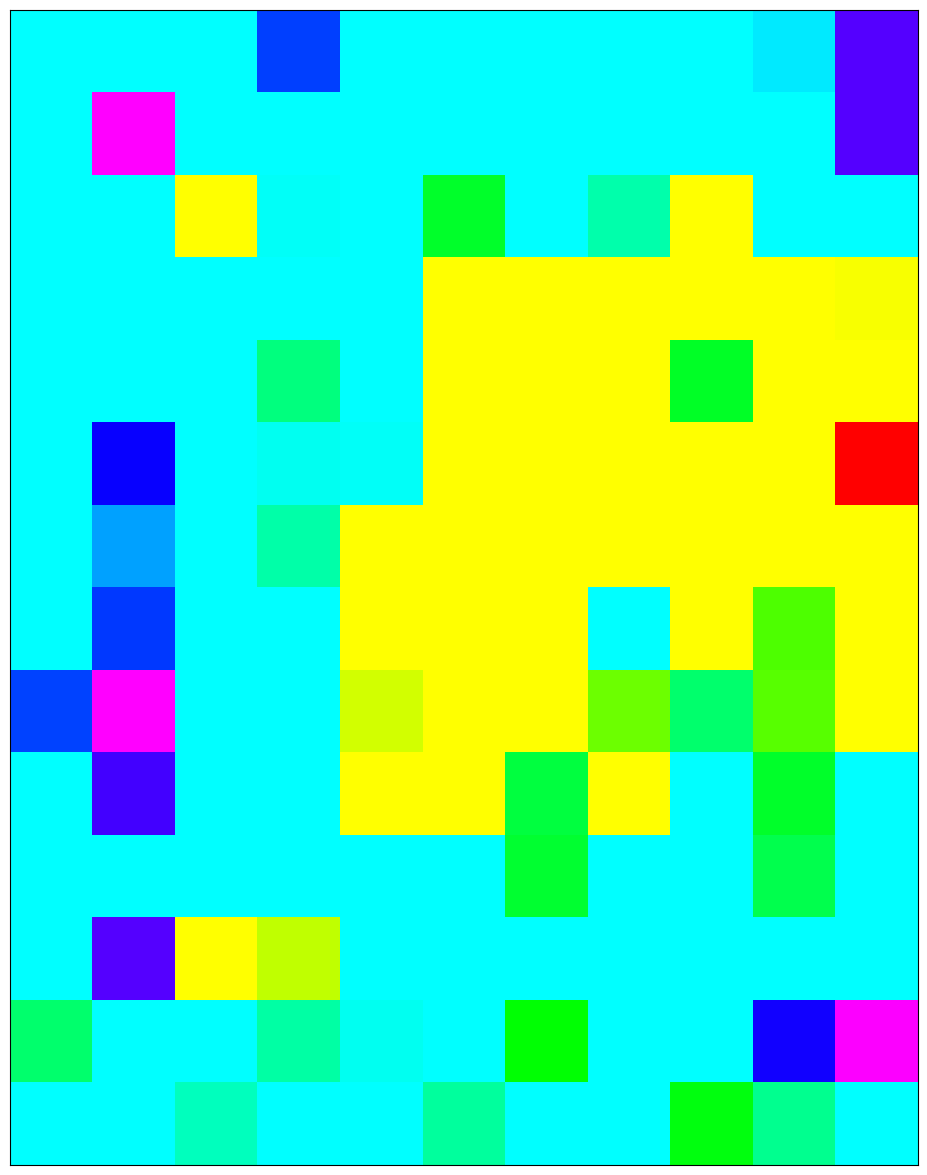

In [6]:
%matplotlib inline

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

plot_image(image, factor=3.5 / 255, clip_range=(0, 1))